<a href="https://colab.research.google.com/github/CakeNuthep/Object-Dectection/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple MINIST

## MNIST Dataset

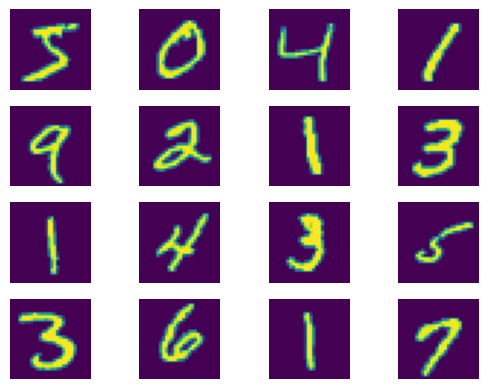

In [1]:
import os
import numpy as np
from keras.datasets import mnist

# load data and reshape the Tensors
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32).reshape((X_train.shape[0],28,28)) / 255.0
X_test  = X_test.astype(np.float32).reshape((X_test.shape[0],28,28)) / 255.0

# convert class vectors to binary class matrices
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

import matplotlib.pyplot as plt
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(X_train[i].reshape((28,28)))
plt.show()

## Simple CNN Model

In [6]:
from keras.layers import (Conv2D, BatchNormalization, Activation, Flatten, Dense)
from keras import Sequential

# Build a model with 14 output nodes
model = Sequential()

model.add( Conv2D(8, (3,3), padding='same', input_shape=(28,28,1)))
model.add( BatchNormalization() )
model.add( Activation('relu') )


model.add( Conv2D(8, (3,3), strides=(2,2), padding='same') ) # -> 14,14,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Conv2D(8, (3,3), strides=(2,2), padding='same')) # -> 7,7,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Flatten() )

model.add( Dense(10, activation='softmax') )
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train.reshape((X_train.shape[0],28,28,1)), Y_train, batch_size=32, epochs=5,
          validation_data=(X_test.reshape((X_test.shape[0],28,28,1)),Y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 28, 28, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 8)         584       
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 14, 14, 8)        

## Change Softmax

In [ ]:
from keras.layers import (Conv2D, BatchNormalization, Activation, Flatten, Dense)
from keras import Sequential
from keras import backend as K

In [ ]:
def my_loss( y_true, y_pred ):
    y_pred_softmax  = K.softmax(y_pred)
    return K.categorical_crossentropy(y_true, y_pred_softmax)

In [7]:
# Build a model with 14 output nodes
model = Sequential()

model.add( Conv2D(8, (3,3), padding='same', input_shape=(28,28,1)))
model.add( BatchNormalization() )
model.add( Activation('relu') )


model.add( Conv2D(8, (3,3), strides=(2,2), padding='same') ) # -> 14,14,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Conv2D(8, (3,3), strides=(2,2), padding='same')) # -> 7,7,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Flatten() )

model.add( Dense(10) )

model.compile(loss=my_loss, optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train.reshape((X_train.shape[0],28,28,1)), Y_train,
          batch_size=32, epochs=5,
          validation_data=(X_test.reshape((X_test.shape[0],28,28,1)),Y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 28, 28, 8)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 8)         584       
                                                                 
 batch_normalization_10 (Bat  (None, 14, 14, 8)        32        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 14, 14, 8)        

# MNIST Dectection

## MNIST Dataset for Object detection

Create Image size: 140 * 140

Label: (x,y,w,h) + 10 class

x,y,w,h was normalized

In [2]:
# create dataset
import cv2
import matplotlib
import matplotlib.pyplot as plt

XX = np.zeros((60000, 140, 140))
YY = []

for t in range(60000):
    ww = 14 + np.random.randint(32)
    w,h = ww+np.random.randint(5), ww+np.random.randint(5)
    xx = cv2.resize(X_train[t], dsize=(h,w), interpolation=cv2.INTER_CUBIC)
    x0,y0 = np.random.randint(140-w), np.random.randint(140-h)
    XX[t, x0:x0+w, y0:y0+h] = xx

    cx, cy = x0+w//2, y0+h//2
    p = [cx/140., cy/140., w/140., h/140.] + Y_train[t].tolist()
    YY.append(p)

XX = XX.reshape((60000, 140,140, 1))
YY = np.array(YY)

## CNN

create loss for bounding box and label

In [104]:
def my_loss( y_true, y_pred ):
  true_bbox, true_cls = y_true[...,:4], y_true[...,4:]
  pred_bbox, pred_cls = y_pred[...,:4], y_pred[...,4:]

  pred_bbox = K.sigmoid(pred_bbox)
  pred_cls  = K.softmax(pred_cls)

  loss_bbox = K.mean( (true_bbox-pred_bbox) ** 2 ) # mse
  loss_cls = K.categorical_crossentropy(true_cls, pred_cls)

  return loss_cls + loss_bbox

In [4]:
from keras.layers import (Conv2D, BatchNormalization, Activation, Flatten, Dense)
from keras import Sequential
from keras import backend as K

# Build a model with 14 output nodes
model = Sequential()

model.add( Conv2D(8, (3,3), padding='same', input_shape=(140,140,1)))
model.add( BatchNormalization() )
model.add( Activation('relu') )


model.add( Conv2D(8, (3,3), strides=(2,2), padding='same') ) # -> 14,14,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Conv2D(8, (3,3), strides=(2,2), padding='same')) # -> 7,7,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Flatten() )

model.add( Dense(14) ) # 10 class + 4 for 1 bbox

model.compile(loss=my_loss, optimizer='adam')
model.fit( XX, YY, batch_size=8, epochs=5 )

Epoch 1/5
7500/7500 [==============================] - 41s 4ms/step - loss: 2.0357
Epoch 2/5
7500/7500 [==============================] - 29s 4ms/step - loss: 1.4210
Epoch 3/5
7500/7500 [==============================] - 28s 4ms/step - loss: 1.0639
Epoch 4/5
7500/7500 [==============================] - 29s 4ms/step - loss: 0.8444
Epoch 5/5
7500/7500 [==============================] - 29s 4ms/step - loss: 0.6954


## USING

1/1 [==============================] - 0s 18ms/step
125 3 139 139 7
139 11 139 139 7
133 11 139 139 7
138 38 139 139 7
134 61 139 139 7
137 85 139 139 7


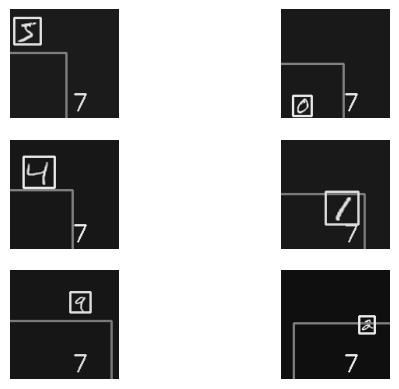

In [6]:
o = model.predict( XX[:6] )

def sigmoid(x):
    return 1./(1. + np.exp(-x))

font        = cv2.FONT_HERSHEY_SIMPLEX
fontScale   = 1
fontColor   = (255,0,0)
lineType    = 2

for t in range(6):
    [cx, cy, w, h] = o[t][:4]
    cx, cy, w, h = int(sigmoid(cx)*140), int(sigmoid(cy)*140), int(sigmoid(w)*140), int(sigmoid(h)*140)

    c = np.argmax( o[t][4:] )

    print(cx, cy, w, h, c)

    out = np.array(255*XX[t].reshape((140,140)))
    cv2.rectangle(out, (int(cy-h//2), int(cx-w//2)), (int(cy+h//2), int(cx+w//2)), 127, 2)

    [cx, cy, w, h] = YY[t][:4]
    cx, cy, w, h = int(cx*140), int(cy*140), int(w*140), int(h*140)
    cv2.rectangle(out, (cy-h//2, cx-w//2), (cy+h//2, cx+w//2), 255, 2)

    cv2.putText(out, str(c),
                (80, 130),
                font,
                fontScale,
                fontColor,
                lineType)

    plt.subplot(3,2,t+1)
    plt.axis('off')
    plt.imshow(out,cmap='gray')
plt.show()

# Multiple box prediction

Multi bounding box.

สมมติว่าระบบทาย 2 กรอบ แต่มีวัตถุจริงแค่อันเดียว
2 กรอบแปลว่าค่าที่ CNN ต้องส่งออกมี 30 ค่า (แต่ละกรอบมี 4 ค่าสำหรับตำแหน่ง 1 ค่า confidence และ 10 ค่าสำหรับคลาสต่าง ๆ)

In [153]:
# create dataset
import cv2
import matplotlib
import matplotlib.pyplot as plt

XX = np.zeros((X_train.shape[0], 140, 140))
YY = []

for t in range(XX.shape[0]):
    ww = 14 + np.random.randint(32)
    w,h = ww+np.random.randint(5), ww+np.random.randint(5)
    xx = cv2.resize(X_train[t], dsize=(h,w), interpolation=cv2.INTER_CUBIC)
    x0,y0 = np.random.randint(140-w), np.random.randint(140-h)
    XX[t, x0:x0+w, y0:y0+h] = xx

    cx, cy = x0+w//2, y0+h//2
    p = [cx/140., cy/140., w/140., h/140., t] # <- we keep index of example
    YY.append(p)


YY = np.array(YY)
XX = XX.reshape(XX.shape[0], 140, 140,1)

## IOU calucalted

พื้นที่ซ้อนเหลื่อม (ส่วนอินเตอร์เซ็คชัน) มีขนาด (20–12)x(12–8) = 8x4 = 32

พื้นที่ยูเนียน = สี่เหลี่ยมน้ำเงิน + สี่เหลี่ยมส้ม – พื้นที่ซ้อนเหลื่อม

พื้นที่ยูเนียน = 10x7 + 13x12 — 32 = 70 + 156–32 = 194

ค่า IoU(น้ำเงิน, ส้ม) = 32/194

In [154]:
def compute_iou(l0, t0, r0, b0, l1, t1, r1, b1):
  roi0 = (b0-t0)*(r0-l0)
  roi1 = (b1-t1)*(r1-l1)
  intersec = (r0-l1)*(b0-t1)
  union = roi0 + roi1 - intersec
  return intersec/union

In [155]:
def prepare_batch( Y_train,
                   XX, YY, batch_size ):

    idx = np.random.randint( XX.shape[0], size=batch_size )
    O = model.predict( XX[idx] )

    ZZ = []
    for t in range(batch_size):

        # target
        [cx0, cy0, w0, h0, i0] = YY[idx[t]]
        l0, t0, r0, b0 = cx0-w0//2, cy0-h0//2, cx0+w0//2, cy0+h0//2

        iou = []
        for i in range(2):
            [cx1, cy1, w1, h1] = O[t][i*15:(i*15+4)]
            l1, t1, r1, b1 = cx1-w1//2, cy1-h1//2, cx1+w1//2, cy1+h1//2

            iou_i = compute_iou( l0, t0, r0, b0, l1, t1, r1, b1 )
            iou.append(iou_i)

        # find best match
        # target confidence for k will be 1
        # target confidence for other bbox will be 0
        k = np.argmax( iou )
        if iou[k]<1e-8:
            k = np.random.randint(2)

        # construct target
        target = []
        for i in range(2):
            j = 1 if i==k else 0
            target = target + [cx0, cy0, w0, h0, j] +  Y_train[int(i0)].tolist()
        target = np.array(target)

        ZZ.append( target )

    return XX[idx], np.array(ZZ)

# CNN

In [180]:
from keras.layers import (Conv2D, BatchNormalization, Activation, Flatten, Dense, Reshape)
from keras.models import Sequential, Model
from keras import backend as K

In [181]:
def my_loss( y_true, y_pred ):
  true_bbox, true_cls = y_true[...,:4], y_true[...,4:]
  pred_bbox, pred_cls = y_pred[...,:4], y_pred[...,4:]

  pred_bbox = K.sigmoid(pred_bbox)
  pred_cls  = K.softmax(pred_cls)

  loss_bbox = K.mean( (true_bbox-pred_bbox) ** 2 ) # mse
  loss_cls = K.categorical_crossentropy(true_cls, pred_cls)

  return loss_cls + loss_bbox

In [182]:
# Build a model with 14 output nodes
model = Sequential()

model.add( Conv2D(8, (3,3), padding='same', input_shape=(140,140,1)))
model.add( BatchNormalization() )
model.add( Activation('relu') )


model.add( Conv2D(8, (3,3), strides=(2,2), padding='same') ) # -> 14,14,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Conv2D(8, (3,3), strides=(2,2), padding='same')) # -> 7,7,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Flatten() )

model.add( Dense(30) ) # 2 bbox, each bbox 4 coord +1conf + 10cls = 15 per bbox


In [183]:
model.compile(loss=my_loss, optimizer='adam')
for epoch in range(5):
  XX_BATCH, YY_BATCH = prepare_batch(Y_train,XX,YY,8)
  model.train_on_batch(XX_BATCH, YY_BATCH)

1/1 [==============================] - 0s 19ms/step


## USING

1/1 [==============================] - 0s 19ms/step
71 68 64 64 11
70 68 65 64 14
70 69 64 64 14
69 68 65 63 14
69 68 64 64 11
70 68 64 64 11


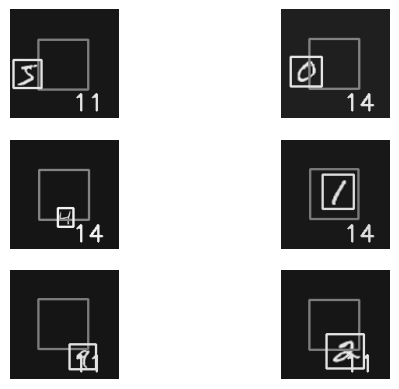

In [162]:
o = model.predict( XX[:6] )

def sigmoid(x):
    return 1./(1. + np.exp(-x))

font        = cv2.FONT_HERSHEY_SIMPLEX
fontScale   = 1
fontColor   = (255,0,0)
lineType    = 2

for t in range(6):
    [cx, cy, w, h] = o[t][:4]
    cx, cy, w, h = int(sigmoid(cx)*140), int(sigmoid(cy)*140), int(sigmoid(w)*140), int(sigmoid(h)*140)

    c = np.argmax( o[t][4:] )

    print(cx, cy, w, h, c)

    out = np.array(255*XX[t].reshape((140,140)))
    cv2.rectangle(out, (int(cy-h//2), int(cx-w//2)), (int(cy+h//2), int(cx+w//2)), 127, 2)

    [cx, cy, w, h] = YY[t][:4]
    cx, cy, w, h = int(cx*140), int(cy*140), int(w*140), int(h*140)
    cv2.rectangle(out, (cy-h//2, cx-w//2), (cy+h//2, cx+w//2), 255, 2)

    cv2.putText(out, str(c),
                (80, 130),
                font,
                fontScale,
                fontColor,
                lineType)

    plt.subplot(3,2,t+1)
    plt.axis('off')
    plt.imshow(out,cmap='gray')
plt.show()

# Update

separate  bounding box with chanel

In [185]:
from keras.layers import (Conv2D, BatchNormalization, Activation, Flatten, Dense, Reshape)
from keras.models import Sequential, Model
from keras import backend as K

In [210]:
def prepare_batch( Y_train,
                   XX, YY, batch_size ):

    idx = np.random.randint( XX.shape[0], size=batch_size )
    O = model.predict( XX[idx] )

    ZZ = []
    for t in range(batch_size):

        # target
        [cx0, cy0, w0, h0, i0] = YY[idx[t]]
        l0, t0, r0, b0 = cx0-w0//2, cy0-h0//2, cx0+w0//2, cy0+h0//2

        iou = []
        for i in range(O.shape[-2]):
            [cx1, cy1, w1, h1] = O[t][..., i,:4]
            l1, t1, r1, b1 = cx1-w1//2, cy1-h1//2, cx1+w1//2, cy1+h1//2

            iou_i = compute_iou( l0, t0, r0, b0, l1, t1, r1, b1 )
            iou.append(iou_i)

        # find best match
        # target confidence for k will be 1
        # target confidence for other bbox will be 0
        k = np.argmax( iou )
        if iou[k]<1e-8:
            k = np.random.randint(2)

        # construct target
        target = []
        for i in range(O.shape[-2]):
            j = 1 if i==k else 0
            target = target + [cx0, cy0, w0, h0, j] +  Y_train[int(i0)].tolist()
        target = np.array(target)
        target = target.reshape(O.shape[-2],15)

        ZZ.append( target )

    return XX[idx], np.array(ZZ)

In [220]:
def my_loss( y_true, y_pred ):

    loss_conf, loss_bbox, loss_cls = 0, 0, 0
    for i in range(y_pred.shape[-2]):
        true_bbox, true_conf, true_cls = y_true[..., i,:4], y_true[..., i,4], y_true[..., i,5:]
        pred_bbox, pred_conf, pred_cls = y_pred[..., i,:4], y_pred[..., i,4], y_pred[..., i,5:]
        pred_conf = K.sigmoid(pred_conf)
        pred_bbox = K.sigmoid(pred_bbox)
        pred_cls  = K.softmax(pred_cls)

        loss_conf = loss_conf + K.binary_crossentropy(true_conf, pred_conf)
        loss_bbox = loss_bbox + true_conf*K.mean( (true_bbox-pred_bbox) ** 2 ) # mse
        loss_cls  = loss_cls  + true_conf*K.categorical_crossentropy(true_cls, pred_cls)

    return loss_conf + loss_bbox + loss_cls

In [221]:


# Build a model with 14 output nodes
model = Sequential()

model.add( Conv2D(8, (3,3), padding='same', input_shape=(140,140,1)))
model.add( BatchNormalization() )
model.add( Activation('relu') )


model.add( Conv2D(8, (3,3), strides=(2,2), padding='same') ) # -> 14,14,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Conv2D(8, (3,3), strides=(2,2), padding='same')) # -> 7,7,8
model.add( BatchNormalization() )
model.add( Activation('relu') )

model.add( Flatten() )

model.add( Dense(30) ) # 2 bbox, each bbox 4 coord +1conf + 10cls = 15 per bbox
model.add( Reshape((2,15)) )
model.summary()
model.compile(loss=my_loss, optimizer='adam')

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_129 (Conv2D)         (None, 140, 140, 8)       80        
                                                                 
 batch_normalization_129 (Ba  (None, 140, 140, 8)      32        
 tchNormalization)                                               
                                                                 
 activation_129 (Activation)  (None, 140, 140, 8)      0         
                                                                 
 conv2d_130 (Conv2D)         (None, 70, 70, 8)         584       
                                                                 
 batch_normalization_130 (Ba  (None, 70, 70, 8)        32        
 tchNormalization)                                               
                                                                 
 activation_130 (Activation)  (None, 70, 70, 8)      

In [217]:
XX_BATCH.shape

(8, 140, 140, 1)

In [218]:
YY_BATCH.shape

(8, 2, 15)

In [224]:
model.compile(loss=my_loss, optimizer='adam')
for epoch in range(5):
  XX_BATCH, YY_BATCH = prepare_batch(Y_train,XX,YY,8)
  model.train_on_batch(XX_BATCH, YY_BATCH)

1/1 [==============================] - 0s 22ms/step


## USING

1/1 [==============================] - 0s 23ms/step
69 68 69 69 0
69 68 69 69 3
70 69 69 69 0
70 69 69 69 0
70 70 69 69 1
69 70 68 68 1


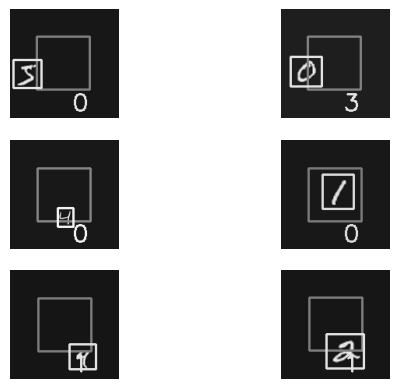

In [227]:
o = model.predict( XX[:6] )

def sigmoid(x):
    return 1./(1. + np.exp(-x))

font        = cv2.FONT_HERSHEY_SIMPLEX
fontScale   = 1
fontColor   = (255,0,0)
lineType    = 2

for t in range(6):
    [cx, cy, w, h] = o[t][..., 0,:4]
    cx, cy, w, h = int(sigmoid(cx)*140), int(sigmoid(cy)*140), int(sigmoid(w)*140), int(sigmoid(h)*140)

    c = np.argmax( o[t][..., 0,:4] )

    print(cx, cy, w, h, c)

    out = np.array(255*XX[t].reshape((140,140)))
    cv2.rectangle(out, (int(cy-h//2), int(cx-w//2)), (int(cy+h//2), int(cx+w//2)), 127, 2)

    [cx, cy, w, h] = YY[t][:4]
    cx, cy, w, h = int(cx*140), int(cy*140), int(w*140), int(h*140)
    cv2.rectangle(out, (cy-h//2, cx-w//2), (cy+h//2, cx+w//2), 255, 2)

    cv2.putText(out, str(c),
                (80, 130),
                font,
                fontScale,
                fontColor,
                lineType)

    plt.subplot(3,2,t+1)
    plt.axis('off')
    plt.imshow(out,cmap='gray')
plt.show()